In [1]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn import random_projection
from cluster_func import em
from cluster_func import kmeans


In [2]:
data_full = pd.read_csv('letter-recognition.data.csv', header=None)

#Randomly sample the data to reduce the size of dataset due to computation difficulty
RandInd = np.random.choice(len(data_full),5000)
data = data_full.iloc[RandInd,:].reset_index().drop(['index'], axis = 1)


X = data.iloc[:,:-1].as_matrix()
y = data.iloc[:,-1].as_matrix()

RandIndFull = np.random.choice(len(data_full), len(data_full))
data_f = data_full.iloc[RandIndFull,:].reset_index().drop(['index'], axis = 1)

X_f = data_f.iloc[:,:-1].as_matrix()
y_f = data_f.iloc[:,-1].as_matrix()

#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


Starting RP
Dimensionality reduction


/anaconda3/lib/python3.6/site-packages/sklearn/random_projection.py:379: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (16 < 17).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


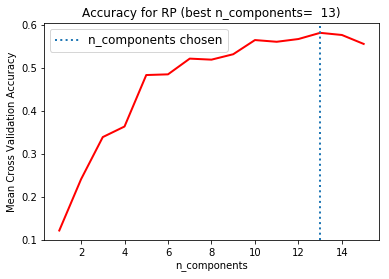

In [8]:
###########################################################################################################################
###########################################################################################################################
#Random projections

print("Starting RP")
print("Dimensionality reduction")


decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
rp = random_projection.GaussianRandomProjection(n_components = 17)

pipe = Pipeline(steps=[('rp', rp), ('decisionTree', decisiontree)])

# Plot the ICA spectrum
rp.fit(X)

fig, ax = plt.subplots()

#Checking the accuracy for taking all combination of components
n_components = range(1, X.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(rp__n_components=n_components), cv = 3)
gridSearch.fit(X, y)
results = gridSearch.cv_results_

#Plotting the accuracies and best component
plt.plot(n_components, results['mean_test_score'], linewidth = 2, color = 'red')
plt.ylabel('Mean Cross Validation Accuracy')
plt.xlabel('n_components')
ax.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy for RP (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['rp'].n_components )
plt.show()


#Reducing the dimensions with optimal number of components
rp_new = random_projection.GaussianRandomProjection(n_components = gridSearch.best_estimator_.named_steps['rp'].n_components)
rp_new.fit(X_train)
X_train_transformed = rp_new.transform(X_train)
X_test_transformed = rp_new.transform(X_test)

Calculating Reconstruction Error


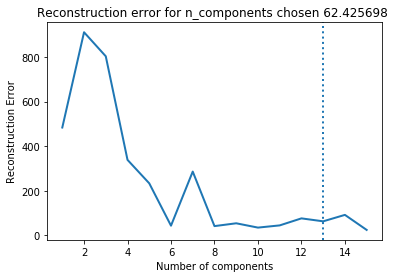

In [9]:
###############################################################################################################################
#Reconstruction Error

print("Calculating Reconstruction Error")

def inverse_transform_rp(rp, X_transformed, X_train):

	return X_transformed.dot(rp.components_) + np.mean(X_train, axis = 0)



reconstruction_error = []
for comp in n_components:

	rp = random_projection.GaussianRandomProjection(n_components = comp)
	X_transformed = rp.fit_transform(X_train)
	X_projected = inverse_transform_rp(rp, X_transformed, X_train)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['rp'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()